In [1]:
import torch
import torch.nn as nn
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

### Corpus y limpieza

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [3]:
lsw = stopwords.words('english')

In [4]:
def clean_data(corpus):
    clean_corpus = []
    for doc in corpus:
        doc_words = doc.split()
        cleaned_doc = [w for w in doc_words if w not in lsw]
        clean_corpus.append(" ".join(cleaned_doc))
    return clean_corpus

In [5]:
clean_corpus = clean_data(corpus)
clean_corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [6]:

def generate_data(clean_corpus, window_size=1):
    data = []
    
    for doc in clean_corpus:
        doc_words = doc.split()
        for i, word in enumerate(doc_words):
            for neighbour in doc_words[max(0,i-window_size):min(len(doc_words),i+window_size+1)]:
                if neighbour != word:
                    data.append((word,neighbour))
            
    df = pd.DataFrame(data,columns=['word','neighbour'])
    return df

In [7]:
data = generate_data(clean_corpus)
data.head()

,word,neighbour
0,king,strong
1,strong,king
2,strong,man
3,man,strong
4,queen,wise


In [8]:
window_size=1
for doc in clean_corpus:
        doc_words = doc.split()
        for i, word in enumerate(doc_words):
            for neighbour in doc_words[max(0,i-window_size):min(len(doc_words),i+window_size+1)]:
                    if neighbour!=word:
                        print(word,neighbour)

king strong
strong king
strong man
man strong
queen wise
wise queen
wise woman
woman wise
boy young
young boy
young man
man young
girl young
young girl
young woman
woman young
prince young
young prince
young king
king young
princess young
young princess
young queen
queen young
man strong
strong man
woman pretty
pretty woman
prince boy
boy prince
boy king
king boy
princess girl
girl princess
girl queen
queen girl


In [9]:
for i, e in enumerate(corpus):
    print(i, e)

0 king is a strong man
1 queen is a wise woman
2 boy is a young man
3 girl is a young woman
4 prince is a young king
5 princess is a young queen
6 man is strong
7 woman is pretty
8 prince is a boy will be king
9 princess is a girl will be queen


### One hot encode vocab

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
vocabulary = list(data['word'].unique())
number_of_words = len(vocabulary)

In [12]:
torch.zeros(number_of_words)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
def one_hot_encode(word,vocabulary):
    vocab_len = len(vocabulary)
    idx = vocabulary.index(word)
    
    onehot_tensor = torch.zeros(vocab_len, device=device)
    onehot_tensor[idx] = 1
    return onehot_tensor


In [14]:
def prepare_train_data(data, vocabulary):
    words = list(data.iloc[:,0])
    neighbours = list(data.iloc[:,1])
    
    x_train = torch.tensor([],device=device)
    y_train = torch.tensor([],device=device)
    
    for i in range(len(words)):
        one_hot_word = one_hot_encode(words[i],vocabulary).unsqueeze(0)
        one_hot_neighbour = one_hot_encode(neighbours[i],vocabulary).unsqueeze(0)
        
        
        x_train = torch.cat((x_train,one_hot_word))
        y_train = torch.cat((y_train,one_hot_neighbour))
        #y_train.append(one_hot_encode(neighbours[i],vocabulary))

    return x_train, y_train

In [15]:
x_train, y_train = prepare_train_data(data,vocabulary)

In [16]:
data

,word,neighbour
0,king,strong
1,strong,king
2,strong,man
3,man,strong
4,queen,wise
5,wise,queen
6,wise,woman
7,woman,wise
8,boy,young
9,young,boy


### W2V Model

In [17]:
x_train.size()[0]

36

In [46]:
class W2V():
    def __init__(self,in_size,vector_size):
        
        self.w1 = torch.rand((in_size,vector_size),device=device,requires_grad=True)
        self.b1 = torch.rand((1,vector_size),device=device,requires_grad=True)
        self.w2 = torch.rand((vector_size,in_size),device=device,requires_grad=True) #in_size = out_size
        self.b2 = torch.rand((1,in_size),device=device,requires_grad=True)
        
        self.optimizer = torch.optim.Adam([self.w1, self.b1, self.w2, self.b2], lr=5e-3)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = x@self.w1+self.b1
        x = x@self.w2+self.b2
        return x
    
    def train_step(self, in_batch, target_batch):
        prediction = self.forward(in_batch)
        
        target = torch.argmax(target_batch,dim=-1, keepdim=True).squeeze()
        
        #loss
        self.optimizer.zero_grad()
        loss = self.criterion(prediction,target)
        loss.backward()
        self.optimizer.step()
        
        return loss.to('cpu').item()
        
        
    def lookup_table(self):
        return (self.w1 + self.b1).to('cpu')

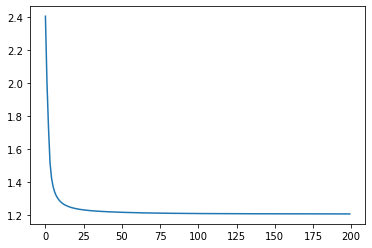

In [62]:
model = W2V(number_of_words,2)
epochs = 20000
plot_steps = 100
losses = []

current_loss = 0

for i in range(epochs):
    loss = model.train_step(x_train,y_train)
    current_loss+=loss
    if (i+1)%plot_steps==0:
        losses.append(current_loss/plot_steps)
        current_loss = 0
plt.figure()
plt.plot(losses)
plt.show()

In [63]:
vectors =model.lookup_table().detach().numpy()
vectors

array([[-18.528389  , -16.662186  ],
       [  9.547239  ,   0.39032245],
       [-20.863194  , -12.746826  ],
       [-15.850521  ,  15.689159  ],
       [  8.328756  ,  -2.3811269 ],
       [-23.318882  ,  15.953999  ],
       [ -0.39794207,   1.1021652 ],
       [  0.83647156,  -0.12383044],
       [ -0.467031  ,  -1.2927041 ],
       [-13.759161  , -12.598026  ],
       [-11.640808  ,  11.702105  ],
       [ 11.2510805 ,  -1.812593  ]], dtype=float32)

In [64]:
x_vectors = vectors[:,0]
y_vectors =  vectors[:,1]

x_vectors = (x_vectors-np.mean(x_vectors))/np.std(x_vectors)
y_vectors = (y_vectors-np.mean(y_vectors))/np.std(y_vectors)

vector_data = np.column_stack((x_vectors,y_vectors))
vector_data

array([[-1.0266664 , -1.6112751 ],
       [ 1.3187069 ,  0.0609921 ],
       [-1.2217106 , -1.2273124 ],
       [-0.8029635 ,  1.5612842 ],
       [ 1.2169176 , -0.2107922 ],
       [-1.4268532 ,  1.5872558 ],
       [ 0.48790935,  0.1307995 ],
       [ 0.5910294 ,  0.0105713 ],
       [ 0.4821378 , -0.10405518],
       [-0.6282561 , -1.2127203 ],
       [-0.45129377,  1.1702906 ],
       [ 1.4610419 , -0.15503848]], dtype=float32)

In [65]:
w2v_df = pd.DataFrame(vectors, columns = ['x', 'y'])
w2v_df['word'] = vocabulary
w2v_df = w2v_df[['word', 'x', 'y']]
w2v_df

,word,x,y
0,king,-18.528389,-16.662186
1,strong,9.547239,0.390322
2,man,-20.863194,-12.746826
3,queen,-15.850521,15.689159
4,wise,8.328756,-2.381127
5,woman,-23.318882,15.953999
6,boy,-0.397942,1.102165
7,young,0.836472,-0.123830
8,girl,-0.467031,-1.292704
9,prince,-13.759161,-12.598026


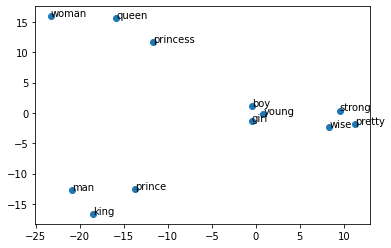

In [66]:
y = w2v_df['y']
x = w2v_df['x']
n = w2v_df['word']

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))